# Rich Logging and printing

In [1]:
# | default_exp logger

In [2]:
# | export
# | hide
import logging
import random, sys
from rich.console import Console
from rich.theme import Theme
from loguru import logger
from datetime import datetime
from fastcore.basics import patch_to, ifnone
from rich.logging import RichHandler
from pathlib import Path
from contextlib import contextmanager
from rich._spinners import SPINNERS

# from torch_snippets.ipython import is_in_notebook

from functools import wraps
import time

In [3]:
# | hide
sys.tracebacklimit = 0

In [ ]:
# | export
# | hide
def get_console(width=None):
    return Console(
        width=width,
        theme=Theme({
            "repr.number": "bold cyan",
            "repr.string": "bold green",
            "logging.level.trace": "dim blue",
            "logging.level.debug": "dim green",
            "logging.level.info": "dim yellow",
            "logging.level.warning": "dim red",
            "logging.level.exception": "bold red",
        }),
    )


logging.addLevelName(5, "TRACE")
console = get_console()
# print = console.print

In [ ]:
# | export
# | hide
@patch_to(RichHandler)
def render(
    self,
    *,
    record,
    traceback,
    message_renderable: "ConsoleRenderable",
) -> "ConsoleRenderable":
    """patched the renderer to print function name as well"""
    path = Path(record.pathname).name
    level = self.get_level_text(record)
    time_format = None if self.formatter is None else self.formatter.datefmt
    log_time = datetime.fromtimestamp(record.created)

    log_renderable = self._log_render(
        self.console,
        [message_renderable] if not traceback else [message_renderable, traceback],
        log_time=log_time,
        time_format=time_format,
        level=level,
        path=path,
        line_no=f"{record.funcName}:{record.lineno}",
        link_path=(
            f"{record.pathname}:{record.lineno}" if self.enable_link_path else None
        ),
    )
    return log_renderable


def reset_logger(
    level="INFO",
    console_width=172,
    silent=True,
    disable_stdout=False,
    show_locals=False,
):
    if level is not None:
        [logger.remove() for _ in range(100)]
        if not disable_stdout:
            logger.configure(
                handlers=[
                    {
                        "sink": RichHandler(
                            rich_tracebacks=True,
                            console=console,
                            tracebacks_show_locals=show_locals,
                        ),
                        "format": "<level>{message}</level>",
                        "backtrace": False,
                        "diagnose": False,
                        "level": level.upper(),
                    }
                ],
            )
    if console_width is not None:
        for handler_id in logger._core.handlers:
            try:
                handler = logger._core.handlers[handler_id]
                handler._sink._handler.console = get_console(width=console_width)
            except:
                ...
    if not silent:
        logger.info(
            f"reset logger's console width to {console_width} and level to {level}!"
        )


def reset_logger_width(width):
    reset_logger(console_width=width)


reset_logger()

logger = logger


def _log(level: str, *x, depth: int = 0, **kwargs):
    msg = x[0] if len(x) == 1 else "; ".join(map(str, x))
    logger.opt(depth=depth + 1, **kwargs).log(level, msg)


def Trace(*x, depth: int = 0):
    _log("TRACE", *x, depth=depth)


def Debug(*x, depth: int = 0):
    _log("DEBUG", *x, depth=depth)


def Info(*x, depth: int = 0):
    _log("INFO", *x, depth=depth)


def Warn(*x, depth: int = 0, is_exception: bool = False):
    _log("WARNING", *x, depth=depth, exception=is_exception)


def Error(*x, depth: int = 0, print_stack_trace: bool = True):
    _log("ERROR", *x, depth=depth, exception=print_stack_trace)


Excep = Error


## Ez logging
Logging is packed in these 5 functions

In [20]:
reset_logger("trace", console_width=80)
Trace("Testing {1,2,3}")
Debug("TESTING {1,2,3}")
Info("TESTING {1,2,3}")
Warn("TESTING {1,2,3}")
Excep("TESTING {1,2,3}")

[08/24/24 12:16:05] TRACE    Testing {1,2,3}            ]8;id=224366;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1838145784.py:2\1838145784.py]8;;\:]8;id=418987;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1838145784.py:2#<module>:2\<module>:2]8;;\

                    DEBUG    TESTING {1,2,3}            ]8;id=937902;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1838145784.py:3\1838145784.py]8;;\:]8;id=471006;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1838145784.py:3#<module>:3\<module>:3]8;;\

                    INFO     TESTING {1,2,3}            ]8;id=231274;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1838145784.py:4\1838145784.py]8;;\:]8;id=492146;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1838145784.py:4#<module>:4\<module>:4]8;;\

                    WARNING  TESTING {1,2,3}            ]8;id=324753;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1838145784.py:5\1838145784.py]8;;\:]8;id=585672;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1838145784.py:5#<module>:5\<module>:5]8;;\

                    ERROR    TESTING {1,2,3}            ]8;id=714335;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1838145784.py:6\1838145784.py]8;;\:]8;id=108282;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1838145784.py:6#<module>:6\<module>:6]8;;\
                             NoneType: None                                     
                                                                                
                                                                                

`Excep` will also print a traceback

In [21]:
def do():
    try:
        1 / 0
    except Exception as e:
        Excep(e)


def do2():
    do()


do2()

[08/24/24 12:16:07] ERROR    division by zero                 ]8;id=376660;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1923207781.py:5\1923207781.py]8;;\:]8;id=229375;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/1923207781.py:5#do:5\do:5]8;;\
                             ZeroDivisionError: division by                     
                             zero                                               
                                                                                
                             ‚ï≠‚îÄ Traceback (most recent call‚îÄ‚ïÆ                   
                             ‚îÇ in do:3                      ‚îÇ                   
                             ‚îÇ                              ‚îÇ                   
                             ‚îÇ    1 def do():               ‚îÇ                   
                             ‚îÇ    2 ‚îÇ   try:                ‚îÇ                   
                             ‚îÇ ‚ù±  3 ‚îÇ   ‚îÇ   1 / 0           ‚îÇ                   
                             ‚îÇ    4 ‚îÇ   except Exception as ‚îÇ                   
                             ‚îÇ    5 ‚îÇ   ‚îÇ   Excep(e)        ‚îÇ                   
                             ‚îÇ    6                         ‚îÇ                   
                             ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ                   
                             ZeroDivisionError: division by                     
                             zero                                               

All logging functions have an optional depth that will be helpful to raise the context level to outer functions

In [22]:
def do():
    Info("In do")


do()

[08/24/24 12:16:15] INFO     In do                             ]8;id=244287;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/809811040.py:2\809811040.py]8;;\:]8;id=530362;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/809811040.py:2#do:2\do:2]8;;\

In [25]:
def do2():
    Info("Log will still say it is from `do2` now, to the right of log print")


def do():
    do2()


do()

[08/24/24 12:17:13] INFO     Log will still say it is from   ]8;id=608563;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/2099333876.py:2\2099333876.py]8;;\:]8;id=696305;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/2099333876.py:2#do2:2\do2:2]8;;\
                             `do2` now, to the right of log                     
                             print                                              

In [27]:
def do2():
    Info("But now, log will still say it is from do", depth=1)


def do():
    do2()


do()

[08/24/24 12:17:25] INFO     But now, log will still say it   ]8;id=342927;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/4054019042.py:5\4054019042.py]8;;\:]8;id=431233;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/4054019042.py:5#do:5\do:5]8;;\
                             is from do                                         

## Logging Level and context

In [ ]:
# | export
def get_logger_level():
    """
    get the current logger's level
    """
    lv = [
        l
        for l, v in logger._core.levels_lookup.items()
        if v[2] == logger._core.min_level
    ][0]
    return lv.lower()


@contextmanager
def _logger_mode_context(level):
    lv = get_logger_level()
    try:
        reset_logger(level.upper())
        yield
    finally:
        reset_logger(lv.upper())


def logger_mode(level):
    """
    temporarily, using `with` context,
    set the level to something else
    """
    if callable(level):
        # Used as a decorator without arguments
        func = level

        @wraps(func)
        def wrapper(*args, **kwargs):
            with _logger_mode_context("DEBUG"):
                return func(*args, **kwargs)

        return wrapper
    else:
        # Used as a decorator with arguments or as a context manager
        def decorator(func):
            @wraps(func)
            def wrapper(*args, **kwargs):
                with _logger_mode_context(level):
                    return func(*args, **kwargs)

            return wrapper

        return _logger_mode_context(level) if not callable(level) else decorator


def in_logger_mode(level: str) -> bool:
    """
    return's T/F, checking if logger is in a specific mode or not
    """
    return get_logger_level() == level


def warn_mode():
    return logger_mode("warning")


def info_mode():
    return logger_mode("info")


def debug_mode():
    return logger_mode("debug")


def trace_mode():
    return logger_mode("trace")


def excep_mode():
    return logger_mode("error")


def in_warn_mode():
    return in_logger_mode("warning")


def in_info_mode():
    return in_logger_mode("info")


def in_debug_mode():
    return in_logger_mode("debug")


def in_trace_mode():
    return in_logger_mode("trace")


def in_excep_mode():
    return in_logger_mode("error")

Let's log every level in the `do` function below.
We can control what we need to log from outside the function's context by  
using `with <level>_model():`

In [9]:
def do():
    Trace(0)
    Debug(1)
    Info(2)
    Warn(3)
    Excep(4)


def line(x):
    sep = "=" * 20
    print(f"{sep}{x}{sep}")
    print(f"{in_excep_mode()=}")
    print(f"{in_warn_mode()=}")
    print(f"{in_info_mode()=}")
    print(f"{in_debug_mode()=}")
    print(f"{in_trace_mode()=}")


reset_logger()

with excep_mode():
    line("Excep mode")
    do()

with warn_mode():
    line("Warn mode")
    do()

with info_mode():
    line("Info mode")
    do()

with debug_mode():
    line("Debug mode")
    do()

with trace_mode():
    line("Trace mode")
    do()

====================Excep mode====================
in_excep_mode()=True
in_warn_mode()=False
in_info_mode()=False
in_debug_mode()=False
in_trace_mode()=False


[08/24/24 12:13:08] ERROR    4                                                                                                                            ]8;id=916055;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:6\3432048509.py]8;;\:]8;id=120477;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:6#do:6\do:6]8;;\
                             NoneType: None                                                                                                                                 
                                                                                                                                                                            
                                                                                                                                                                            

====================Warn mode====================
in_excep_mode()=False
in_warn_mode()=True
in_info_mode()=False
in_debug_mode()=False
in_trace_mode()=False


[08/24/24 12:13:08] WARNING  3                                                                                                                            ]8;id=218910;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:5\3432048509.py]8;;\:]8;id=668161;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:5#do:5\do:5]8;;\

                    ERROR    4                                                                                                                            ]8;id=184912;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:6\3432048509.py]8;;\:]8;id=71750;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:6#do:6\do:6]8;;\
                             NoneType: None                                                                                                                                 
                                                                                                                                                                            
                                                                                                                                                                            

====================Info mode====================
in_excep_mode()=False
in_warn_mode()=False
in_info_mode()=True
in_debug_mode()=False
in_trace_mode()=False


[08/24/24 12:13:08] INFO     2                                                                                                                            ]8;id=336403;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:4\3432048509.py]8;;\:]8;id=881230;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:4#do:4\do:4]8;;\

                    WARNING  3                                                                                                                            ]8;id=335362;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:5\3432048509.py]8;;\:]8;id=481605;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:5#do:5\do:5]8;;\

                    ERROR    4                                                                                                                            ]8;id=121173;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:6\3432048509.py]8;;\:]8;id=696301;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:6#do:6\do:6]8;;\
                             NoneType: None                                                                                                                                 
                                                                                                                                                                            
                                                                                                                                                                            

====================Debug mode====================
in_excep_mode()=False
in_warn_mode()=False
in_info_mode()=False
in_debug_mode()=True
in_trace_mode()=False


[08/24/24 12:13:08] DEBUG    1                                                                                                                            ]8;id=523515;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:3\3432048509.py]8;;\:]8;id=65924;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:3#do:3\do:3]8;;\

                    INFO     2                                                                                                                            ]8;id=428047;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:4\3432048509.py]8;;\:]8;id=902182;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:4#do:4\do:4]8;;\

                    WARNING  3                                                                                                                            ]8;id=768299;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:5\3432048509.py]8;;\:]8;id=755565;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:5#do:5\do:5]8;;\

                    ERROR    4                                                                                                                            ]8;id=203848;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:6\3432048509.py]8;;\:]8;id=459920;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:6#do:6\do:6]8;;\
                             NoneType: None                                                                                                                                 
                                                                                                                                                                            
                                                                                                                                                                            

====================Trace mode====================
in_excep_mode()=False
in_warn_mode()=False
in_info_mode()=False
in_debug_mode()=False
in_trace_mode()=True


[08/24/24 12:13:08] TRACE    0                                                                                                                            ]8;id=353756;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:2\3432048509.py]8;;\:]8;id=420809;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:2#do:2\do:2]8;;\

                    DEBUG    1                                                                                                                            ]8;id=12861;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:3\3432048509.py]8;;\:]8;id=936132;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:3#do:3\do:3]8;;\

                    INFO     2                                                                                                                            ]8;id=464736;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:4\3432048509.py]8;;\:]8;id=856526;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:4#do:4\do:4]8;;\

                    WARNING  3                                                                                                                            ]8;id=696903;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:5\3432048509.py]8;;\:]8;id=821308;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:5#do:5\do:5]8;;\

                    ERROR    4                                                                                                                            ]8;id=181087;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:6\3432048509.py]8;;\:]8;id=999705;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3432048509.py:6#do:6\do:6]8;;\
                             NoneType: None                                                                                                                                 
                                                                                                                                                                            
                                                                                                                                                                            

The `in_<level>_mode` gives an additional layer of control, to be used for debugging dynamically. Let's say, you want to show an image (for the sake of debugging)

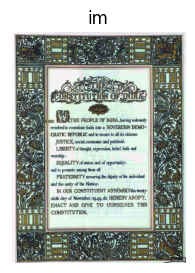

145.5542982442515


In [34]:
def do(im_path):
    from torch_snippets import show, read

    im = read(im_path)
    show(im, sz=3)
    print(im.mean())


do("assets/Preamble.png")

But now you are happy with your code and don't want the show, say the code is going to production. A common way out is to just comment that line

In [36]:
def do(im_path):
    from torch_snippets import show, read

    im = read(im_path)
    # show(im, sz=3) # line is commented, but will need to be re-uncommented any time it needs debugging
    print(im.mean())


do("assets/Preamble.png")

145.5542982442515


But if you want to re-check, it's a pain to again uncomment. Not to mention this method is not scalable to 100s of lines of code. The simple way to deal with such transient code that needs to activate only when you want it to, is to enclose in an `if in_<level>_mode` conditional like so

In [37]:
def do(im_path):
    from torch_snippets import show, read

    im = read(im_path)
    if in_debug_mode():
        show(im, sz=3)
    print(im.mean())


do("assets/Preamble.png")

145.5542982442515


This way, you can always activate the show by calling `do` with a temporary `with_debug_mode` context

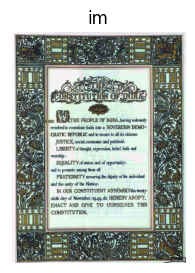

145.5542982442515


In [39]:
with debug_mode():
    do("assets/Preamble.png")

## Notify Waiting

In [63]:
# | export
# | hide

frames = [
    "Guess the anime (while you wait): üç•üçÉüî•ü•ãü¶äüçúüåÜüåÑ    ",  # Naruto
    "Guess the anime (while you wait): üêâüí•ü•ãüöÄüî•üê≤üååüçÉ    ",  # Dragon Ball Z
    "Guess the anime (while you wait): üëí‚ò†Ô∏è‚õµüè¥‚Äç‚ò†Ô∏èüçñüçóüåäüèùÔ∏èüêí  ",  # One Piece
    "Guess the anime (while you wait): ü™∂üè∞üßë‚Äçüî¨ü¶øü™ìüåÖüê¶üëπ    ",  # Attack on Titan
    "Guess the anime (while you wait): üìì‚úíÔ∏èüßë‚Äç‚öñÔ∏è‚ò†Ô∏èüïäÔ∏èüîçüåÉ      ",  # Death Note
    "Guess the anime (while you wait): üîßüîÆ‚öóÔ∏èü§ñüëÅÔ∏è‚Äçüó®Ô∏èüí•üî•      ",  # Fullmetal Alchemist
    "Guess the anime (while you wait): ü¶∏‚Äç‚ôÇÔ∏èü¶∏‚Äç‚ôÄÔ∏èüí•üè´üåüüåÜüî•      ",  # My Hero Academia
    "Guess the anime (while you wait): ü§ñüåÉüååüõ∞Ô∏èü™êüëÅÔ∏è‚Äçüó®Ô∏èüí•      ",  # Neon Genesis Evangelion
    "Guess the anime (while you wait): ü§†üöÄüååüé∑üåüüî´üí∞      ",  # Cowboy Bebop
    "Guess the anime (while you wait): üëßüêâüèØüåüüçúüõÅüåå      ",  # Spirited Away
    "Guess the movie (while you wait): üååüöÄüå†ü™êü§ñüëΩüî±‚ú®üöÅüåë",  # Star Wars
    "Guess the movie (while you wait): üßôüè∞üåãüó°Ô∏èüëëüêâü™∂üçÉü¶Öüíç",  # The Lord of the Rings
    "Guess the movie (while you wait): üßô‚Äç‚ôÇÔ∏è‚ö°üè∞ü™Ñü¶âüîÆüöÇüêçüßπüìö",  # Harry Potter
    "Guess the movie (while you wait): üåøüåèüöÅüíéüí´üåûü¶ãüêâüçÉüî∂",  # Avatar
    "Guess the movie (while you wait): üè¥‚Äç‚ò†Ô∏è‚öìü¶úüåäüí∞üö¢üî´üå¥üó∫Ô∏èüî™",  # Pirates of the Caribbean
    "Guess the movie (while you wait): üï∂Ô∏èüåêüíäüèôÔ∏èüßë‚Äçüíªüî´ü™ëüïäÔ∏èü¶π‚Äç‚ôÇÔ∏èüîµ",  # The Matrix
    "Guess the movie (while you wait): ü¶∏‚Äç‚ôÇÔ∏èü¶∏‚Äç‚ôÄÔ∏èüåüü¶π‚Äç‚ôÇÔ∏èü¶π‚Äç‚ôÄÔ∏èüí•üåÜü§ñüî®üõ°Ô∏è",  # The Avengers
    "Guess the movie (while you wait): ü¶ñü¶ïüå¥ü™∂ü™∂ü™∂üöÅüßë‚Äçüî¨ü™∂üßë‚Äçüî¨",  # Jurassic Park
    "Guess the movie (while you wait): ü¶ÅüëëüåÖüå¥üêóüêæüé∂üëëü¶èüêò",  # The Lion King
    "Guess the movie (while you wait): üß∏ü§†üöÄüßíüêçü™Åüéàüéâü§ñüëæ",  # Toy Story
    "Guess the movie (while you wait): ‚ùÑÔ∏èüëë‚õÑ‚ùÑÔ∏èüßù‚Äç‚ôÄÔ∏èü¶åüè∞üé∂üèîÔ∏èüå¨Ô∏è",  # Frozen
    "Guess the movie (while you wait): üö¢üåä‚ùÑÔ∏èüíîüéªüî±‚öìüö¢üåüüåÖ",  # Titanic
    "Guess the movie (while you wait): üö≤üëΩüåïüå±üååüå†üåüü™êüë®‚Äçüî¨üõ∏",  # E.T. the Extra-Terrestrial
    "Guess the movie (while you wait): üìúüóùÔ∏èüè¢üîìüß±üßîüí∞üö∂‚Äç‚ôÇÔ∏è‚õèÔ∏èüåÖ",  # The Shawshank Redemption
    "Guess the movie (while you wait): üèÉüå≥üéìüèàüç´üèÖüç§üöåüç§ü¶ê",  # Forrest Gump
    "Guess the movie (while you wait): üçäüé©üë®‚Äçüë©‚Äçüë¶üî´üç∑üáÆüáπüï∂Ô∏èüìùüö¨üíî",  # The Godfather
]


@contextmanager
def notify_waiting(message, spinner="clock"):
    """Use a with context to let the user know that something is happening with a
    dynamic spinner
    """
    random.shuffle(frames)
    SPINNERS["guess_the_movie"] = {"interval": 3000, "frames": frames}
    Trace(f"Available Spinners: {SPINNERS.keys()}\n\nUsing: {spinner}")

    status = console.status(f"[red]\n{message:10}", spinner=spinner)
    with status as _:
        s = time.perf_counter()
        yield
        time_taken = time.perf_counter() - s
        time.sleep(0.1)
    Info(f"{message} - Completed in {time_taken:.2f} s", depth=1)

In [67]:
reset_logger(console_width=100)

with trace_mode():
    with notify_waiting("Downloading"):
        time.sleep(10)

with notify_waiting("Downloading", spinner="guess_the_movie"):
    time.sleep(10)

with notify_waiting("One more message", spinner="earth"):
    time.sleep(3)

[08/24/24 12:36:51] TRACE    Available Spinners: dict_keys(['dots', 'dots2', 'dots3', 'dots4', 'dots5', 'dots6', 'dots7', 'dots8', 'dots9',  ]8;id=248925;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3340474699.py:41\3340474699.py]8;;\:]8;id=418244;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_44029/3340474699.py:41#notify_waiting:41\notify_waiting:41]8;;\
                             'dots10', 'dots11', 'dots12', 'dots8Bit', 'line', 'line2', 'pipe', 'simpleDots', 'simpleDotsScrolling', 'star',                                
                             'star2', 'flip', 'hamburger', 'growVertical', 'growHorizontal', 'balloon', 'balloon2', 'noise', 'bounce',                                      
                             'boxBounce', 'boxBounce2', 'triangle', 'arc', 'circle', 'squareCorners', 'circleQuarters', 'circleHalves',                                     
                             'squish', 'toggle', 'toggle2', 'toggle3', 'toggle4', 'toggle5', 'toggle6', 'toggle7', 'toggle8', 'toggle9',                                    
                             'toggle10', 'toggle11', 'toggle12', 'toggle13', 'arrow', 'arrow2', 'arrow3', 'bouncingBar', 'bouncingBall',                                    
                             'smiley', 'monkey', 'hearts', 'clock', 'earth', 'material', 'moon', 'runner', 'pong', 'shark', 'dqpb',                                         
                             'weather', 'christmas', 'grenade', 'point', 'layer', 'betaWave', 'aesthetic', 'guess', 'guess_the_movie'])                                     
                                                                                                                                                                            
                             Using: clock                                                                                                                                   

Output()

[08/24/24 12:37:01] INFO     Downloading - Completed in 10.01 s                                                                                   ]8;id=4266;file:///opt/miniconda3/lib/python3.12/contextlib.py:144\contextlib.py]8;;\:]8;id=46533;file:///opt/miniconda3/lib/python3.12/contextlib.py:144#__exit__:144\__exit__:144]8;;\

Output()

[08/24/24 12:37:11] INFO     Downloading - Completed in 10.01 s                                                                                   ]8;id=137393;file:///opt/miniconda3/lib/python3.12/contextlib.py:144\contextlib.py]8;;\:]8;id=906004;file:///opt/miniconda3/lib/python3.12/contextlib.py:144#__exit__:144\__exit__:144]8;;\

Output()

[08/24/24 12:37:14] INFO     One more message - Completed in 3.00 s                                                                               ]8;id=247746;file:///opt/miniconda3/lib/python3.12/contextlib.py:144\contextlib.py]8;;\:]8;id=719324;file:///opt/miniconda3/lib/python3.12/contextlib.py:144#__exit__:144\__exit__:144]8;;\

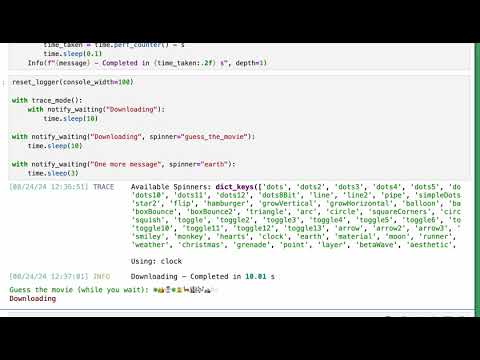

In [68]:
# | echo: false
from IPython.display import YouTubeVideo

YouTubeVideo("HGsG0jVFREY", width=560, height=315)